In [ ]:
pip install elementpath

     |████████████████████████████████| 153kB 2.8MB/s 


In [ ]:
!nvidia-smi

Sat May 29 08:40:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%cd
  
!git clone --quiet https://github.com/matterport/Mask_RCNN.git

/root


In [4]:
%cd ~/Mask_RCNN

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

/root/Mask_RCNN
     |████████████████████████████████| 204kB 6.9MB/s 
     |████████████████████████████████| 163kB 34.8MB/s 
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links t

In [5]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


#   Validating the data set 

In [6]:
# Extracting the boxes from 
"""

Task 1: Using the ElementTree API I am parse the entire xml 
Goal: Is to extract the box, and annoted image dimensions

"""

'\n\nTask 1: Using the ElementTree API I am parse the entire xml \nGoal: Is to extract the box, and annoted image dimensions\n\n'

In [7]:
from xml.etree import ElementTree

In [8]:
# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
	# load and parse the file
	tree = ElementTree.parse(filename)
	# get the root of the document
	root = tree.getroot()
	# extract each bounding box
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = float(box.find('xmin').text)
		ymin = float(box.find('ymin').text)
		xmax = float(box.find('xmax').text)
		ymax = float(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	# extract image dimensions
	width = int(root.find('.//size/width').text)
	height = int(root.find('.//size/height').text)
	return boxes, width, height

In [9]:
# extract details form annotation file
boxes, w, h = extract_boxes('/content/drive/MyDrive/Colab Notebooks/treespecies/labels/00001.xml')
# summarize extracted details
print(boxes, w, h)

[[104.88, 237.03, 669.83, 605.05]] 960 720


In [20]:
# split into train and test set
# Creating a dataset for tree
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
 
# class that defines and loads the kangaroo dataset
class TreeSpeciesDataset(Dataset):

	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "treespecies")
		# define data locations
		images_dir = dataset_dir + '/image/'
		annotations_dir = dataset_dir + '/labels/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 40:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 40:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = round(float((box.find('xmin').text)))
			ymin = round(float((box.find('ymin').text)))
			xmax = round(float((box.find('xmax').text)))
			ymax = round(float((box.find('ymax').text)))
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('treespecies'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']
 

In [21]:
#training set
train_set = TreeSpeciesDataset()
train_set.load_dataset('/content/drive/MyDrive/Colab Notebooks/treespecies', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
#print(f'\n{train_set.image_ids}')

# test/val set
test_set = TreeSpeciesDataset()
test_set.load_dataset('/content/drive/MyDrive/Colab Notebooks/treespecies', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 39
Test: 11


## Test the Treespecies Dataset

In [22]:
# train set
train_set = TreeSpeciesDataset()
train_set.load_dataset('/content/drive/MyDrive/Colab Notebooks/treespecies', is_train=True)
train_set.prepare()

In [23]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)

(960, 720, 3)


In [24]:
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(720, 960, 1)


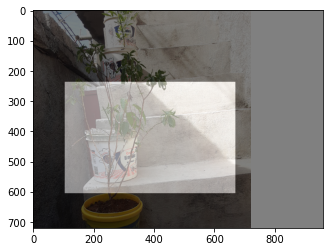

In [25]:
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

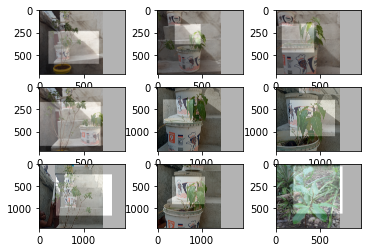

In [26]:
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [27]:

# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)
 

{'id': '00001', 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/treespecies/image/00001.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/treespecies/labels/00001.xml'}
{'id': '00002', 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/treespecies/image/00002.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/treespecies/labels/00002.xml'}
{'id': '00003', 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/treespecies/image/00003.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/treespecies/labels/00003.xml'}
{'id': '00004', 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/treespecies/image/00004.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/treespecies/labels/00004.xml'}
{'id': '00005', 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/treespecies/image/00005.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/treespecies/labels/00005.xml'}


In [40]:
# display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes


# class that defines and loads the kangaroo dataset
class TreeSpeciesDataset(Dataset):

	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "treespecies")
		# define data locations
		images_dir = dataset_dir + '/image/'
		annotations_dir = dataset_dir + '/labels/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 40:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 40:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = round(float((box.find('xmin').text)))
			ymin = round(float((box.find('ymin').text)))
			xmax = round(float((box.find('xmax').text)))
			ymax = round(float((box.find('ymax').text)))
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('treespecies'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

In [41]:

# train set
train_set = TreeSpeciesDataset()
train_set.load_dataset('/content/drive/MyDrive/Colab Notebooks/treespecies', is_train=True)
train_set.prepare()
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)


In [1]:
# display image with masks and bounding boxes
#display_instances(image, bbox, mask, class_ids, train_set.class_names)